In [1]:
import easyocr
import numpy as np
import pandas as pd

In [2]:
X = np.load('c:/3rd_project/data/images/movie/X_total_color.npy')
y = np.load('c:/3rd_project/data/images/movie/y_total_color.npy')

In [3]:
X[0]

array([[[245, 255, 255],
        [242, 252, 254],
        [246, 255, 255],
        ...,
        [250, 250, 252],
        [254, 255, 255],
        [254, 255, 255]],

       [[194, 217, 231],
        [197, 220, 233],
        [194, 216, 229],
        ...,
        [245, 245, 247],
        [240, 241, 243],
        [238, 239, 241]],

       [[193, 217, 227],
        [193, 217, 228],
        [194, 216, 227],
        ...,
        [250, 249, 254],
        [249, 250, 252],
        [241, 242, 244]],

       ...,

       [[241, 242, 244],
        [241, 242, 244],
        [241, 242, 244],
        ...,
        [239, 240, 242],
        [240, 240, 242],
        [240, 240, 242]],

       [[241, 242, 244],
        [241, 242, 244],
        [241, 242, 244],
        ...,
        [239, 240, 242],
        [240, 240, 242],
        [240, 240, 242]],

       [[241, 242, 244],
        [241, 242, 244],
        [241, 242, 244],
        ...,
        [239, 240, 242],
        [240, 240, 242],
        [240, 240, 242]]

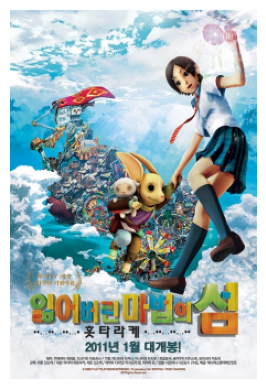

In [4]:
import cv2
from matplotlib import pyplot as plt

num = 0
img = X[num]

# 이미지 표시
plt.imshow(img)
plt.axis("off")
plt.show()

reader = easyocr.Reader(['ko','en'])
result = reader.readtext(X[num])

In [5]:
result

[([[17, 255], [73, 255], [73, 291], [17, 291]], '얇에;', 0.08566171786230196),
 ([[67, 285], [107, 285], [107, 301], [67, 301]], '롯타라', 0.4268792153685138),
 ([[67, 299], [155, 299], [155, 315], [67, 315]],
  '2t년 1업 대개봉',
  0.15750403581586564),
 ([[32, 316], [62, 316], [62, 322], [32, 322]], '오부 무', 0.0023596591781824827)]

In [6]:
len(X)

7005

In [7]:
import easyocr
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image

from konlpy.tag import Kkma

class Ocr:
    def __init__(self, img):
        self.img = img

    def text_detect(self):
        # img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
        reader = easyocr.Reader(['ko', 'en'], gpu = True)
        result = reader.readtext(self.img)

        # img = cv2.resize(img_cv2, (320, 448))
        image = Image.fromarray(self.img)
        font = ImageFont.truetype('C:/Users/tjoeun/AppData/Local/Microsoft/Windows/Fonts/NanumGothicBold.ttf', 10)
        draw = ImageDraw.Draw(image)
        np.random.seed(42)
        COLORS = np.random.randint(0, 255, size=(255, 3),dtype="uint8")
        for i in result :
            x = i[0][0][0] 
            y = i[0][0][1] 
            w = i[0][1][0] - i[0][0][0] 
            h = i[0][2][1] - i[0][1][1]

            color_idx = random.randint(0,255) 
            color = [int(c) for c in COLORS[color_idx]]

            draw.rectangle(((x, y), (x+w, y+h)), outline=tuple(color), width=2)
            draw.text((int((x + x + w) / 2) , y-2),str(i[1]), font=font, fill=tuple(color),)

        # plt.figure(figsize=(10,20))
        plt.imshow(image)
        plt.axis("off")
        plt.show()
        # print(result)

    def image_to_text(self):
        # 추출된 텍스트 영역을 이용하여 각각의 텍스트를 잘라내고 EasyOCR을 다시 적용
        reader = easyocr.Reader(['ko', 'en'], gpu=True)
        result = reader.readtext(self.img)
        
        origin_results = []
        roi_results = []
        roi_gray_results =[]
        roi_2_results =[]
        roi_equal_results =[]
        roi_dil_results =[]
        roi_ero_results =[]
        roi_canny_results =[]

        for (box, text, confidence) in result:
            try:
                origin_results.append(text)
            except:
                pass

            # 각 텍스트 박스의 좌표 추출
            (startX, startY) = box[0]
            (endX, endY) = box[2]
            
            # 좌표를 정수로 변환
            startX, startY, endX, endY = int(startX), int(startY), int(endX), int(endY)

            # print(startX, startY, endX, endY)
            # 좌표가 음수이거나 이미지 범위를 벗어나는 경우 무시
            if startX < 0 or startY < 0 or endX >= self.img.shape[1] or endY >= self.img.shape[0]:
                continue

            # 텍스트 영역 추출
            roi = self.img[startY:endY, startX:endX]

            ############################################# 이미지 전처리 ###################################################

            # 이미지를 그레이스케일로 변환
            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

            # 적응형 이진화 수행
            roi_adaptive_thresh = cv2.adaptiveThreshold(roi_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)

            # 히스토그램 평탄화 수행
            roi_equalized = cv2.equalizeHist(roi_gray)

            # 팽창
            kernel = np.ones((3, 3), np.uint8)
            roi_dilation = cv2.dilate(roi, kernel, iterations=1)

            # 침식
            kernel = np.ones((3, 3), np.uint8)
            roi_erosion = cv2.erode(roi, kernel, iterations=1)

            # 캐니
            roi_canny = cv2.Canny(roi, 475, 500, apertureSize=3, L2gradient=True)

            ############################################# 텍스트 인식 ###################################################

            # 잘라낸 텍스트 영역에 EasyOCR을 적용
            roi_result = reader.readtext(roi)
            roi_gray_result = reader.readtext(roi_gray)
            roi_2_result = reader.readtext(roi_adaptive_thresh)
            roi_equal_result = reader.readtext(roi_equalized)
            roi_dil_result = reader.readtext(roi_dilation)
            roi_ero_result = reader.readtext(roi_erosion)
            roi_canny_result = reader.readtext(roi_canny)

            ############################################# 결과 출력 ###################################################

            # print("부분")
            # plt.imshow(roi)
            try:
                # print(f'Text: {roi_result[0][1]}, Confidence: {roi_result[0][2]}')
                roi_results.append(roi_result[0][1])
            except:
                # print("Not Detect")
                roi_results.append('None')
            # plt.axis('off')
            # plt.show()

            # print("그레이 스케일")
            # plt.imshow(roi_gray, cmap="gray")
            try:
                # print(f'Text: {roi_gray_result[0][1]}, Confidence: {roi_gray_result[0][2]}')
                roi_gray_results.append(roi_gray_result[0][1])
            except:
                # print("Not Detect")
                roi_gray_results.append('None')
            # plt.axis('off')
            # plt.show()

            # print("적응형 이진화")
            # plt.imshow(roi_adaptive_thresh, cmap="gray")
            try:
                # print(f'Text: {roi_2_result[0][1]}, Confidence: {roi_2_result[0][2]}')
                roi_2_results.append(roi_2_result[0][1])
            except:
                # print("Not Detect")
                roi_2_results.append('None')
            # plt.axis('off')
            # plt.show()

            # print("히스토그램 평탄화")
            # plt.imshow(roi_equalized)
            try:
                # print(f'Text: {roi_equal_result[0][1]}, Confidence: {roi_equal_result[0][2]}')
                roi_equal_results.append(roi_equal_result[0][1])
            except:
                # print("Not Detect")
                roi_equal_results.append('None')
            # plt.axis('off')
            # plt.show()

            # print("팽창")
            # plt.imshow(roi_dilation)
            try:
                # print(f'Text: {roi_dil_result[0][1]}, Confidence: {roi_dil_result[0][2]}')
                roi_dil_results.append(roi_dil_result[0][1])
            except:
                # print("Not Detect")
                roi_dil_results.append('None')
            # plt.axis('off')
            # plt.show()

            # print("침식")
            # plt.imshow(roi_erosion)
            try:
                # print(f'Text: {roi_ero_result[0][1]}, Confidence: {roi_ero_result[0][2]}')
                roi_ero_results.append(roi_ero_result[0][1])
            except:
                # print("Not Detect")
                roi_ero_results.append('None')
            # plt.axis('off')
            # plt.show()

            # print("캐니")
            # plt.imshow(roi_canny)
            try:
                # print(f'Text: {roi_canny_result[0][1]}, Confidence: {roi_canny_result[0][2]}')
                roi_canny_results.append(roi_canny_result[0][1])
            except:
                # print("Not Detect")
                roi_canny_results.append('None')
            # plt.axis('off')
            # plt.show()
        return origin_results, roi_results, roi_gray_results, roi_2_results, roi_equal_results, roi_dil_results, roi_ero_results, roi_canny_results


class Get_Nouns:
    def __init__(self, i2t_text):
        self.text = i2t_text

    def get_nouns(self):
        kkma = Kkma()
        nouns = kkma.nouns(str(self.text))
        return nouns

    def get_nouns_list(self):
        i2t_nouns = self.get_nouns()

        noun_list = []

        # 추출된 명사 출력
        for i2t_noun in i2t_nouns:
            if len(i2t_noun) > 1:
                noun_list.append(i2t_noun)

        noun_list = list(set(noun_list))
        return noun_list

### 장르별 단어 txt파일 생성

In [ ]:
# from tqdm import tqdm

# act_nouns = []
# ani_nouns = []
# com_nouns = []
# dra_nouns = []
# hor_nouns = []
# etc_nouns = []

# for num in tqdm(range(len(X))):
#     img = X[num]

#     try:
#         ocr = Ocr(img)
#         # ocr.text_detect()
#         i2t_text = ocr.image_to_text()
#         # print(y[num])
#         gn = Get_Nouns(i2t_text)
#         nouns = gn.get_nouns_list()
#         nouns = list(set(nouns))
#     except:
#         print(num)

#     if y[num] == '액션':
#         for noun in nouns:
#             act_nouns.append(noun)
#     elif y[num] == '애니메이션':
#         for noun in nouns:
#             ani_nouns.append(noun)
#     elif y[num] == '코미디':
#         for noun in nouns:
#             com_nouns.append(noun)
#     elif y[num] == '드라마':
#         for noun in nouns:
#             dra_nouns.append(noun)
#     elif y[num] == '공포(호러)':
#         for noun in nouns:
#             hor_nouns.append(noun)
#     else:
#         for noun in nouns:
#             etc_nouns.append(noun)

In [ ]:
# print(act_nouns)
# print(ani_nouns)
# print(com_nouns)
# print(dra_nouns)
# print(hor_nouns)
# print(etc_nouns)

In [ ]:
# act_nouns = list(set(act_nouns))
# ani_nouns = list(set(ani_nouns))
# com_nouns = list(set(com_nouns))
# dra_nouns = list(set(dra_nouns))
# hor_nouns = list(set(hor_nouns))
# etc_nouns = list(set(etc_nouns))

# print(len(act_nouns))
# print(len(ani_nouns))
# print(len(com_nouns))
# print(len(dra_nouns))
# print(len(hor_nouns))
# print(len(etc_nouns))

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity

# genre = ['액션', '애니매이션', '코미디', '드라마', '공포(호러)', '기타']

# # 문서 코퍼스 생성
# corpus = [
#     ' '.join(act_nouns),
#     ' '.join(ani_nouns),
#     ' '.join(com_nouns),
#     ' '.join(dra_nouns),
#     ' '.join(hor_nouns),
#     ' '.join(etc_nouns)
# ]

# # TF-IDF 벡터화
# tfidf_vectorizer = TfidfVectorizer()
# tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# # 입력 단어
# input_word = '감동'

# # 입력 단어를 TF-IDF 벡터로 변환
# input_vector = tfidf_vectorizer.transform([input_word])

# # 각 카테고리와의 코사인 유사도 계산
# similarities = cosine_similarity(input_vector, tfidf_matrix)

# print(similarities)
# print(similarities.argmax())
# # 유사도가 가장 높은 카테고리 선택
# most_similar_category = genre[similarities.argmax()]

# # 결과 출력
# print(f"입력 단어 '{input_word}'와(과) 가장 유사한 카테고리: {most_similar_category}")

In [ ]:
# act_nouns
# ani_nouns
# com_nouns
# dra_nouns
# hor_nouns
# etc_nouns 

# 리스트를 텍스트 파일로 저장
# with open('c:/3rd_project/data/etc_nouns.txt', 'w', encoding='utf-8') as f:
#     for item in etc_nouns:
#         f.write("%s\n" % item)

### 장르별 단어 txt파일 불러오기

In [9]:
def read_words_from_file(file_path):
    words = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # 줄바꿈 문자를 제거하고 단어를 리스트에 추가
            word = line.strip()
            words.append(word)
    return words

# 파일로부터 단어 리스트 불러오기
act_nouns = read_words_from_file('c:/3rd_project/Data/Nouns_Dict/act_nouns.txt')
ani_nouns = read_words_from_file('c:/3rd_project/Data/Nouns_Dict/ani_nouns.txt')
com_nouns = read_words_from_file('c:/3rd_project/Data/Nouns_Dict/com_nouns.txt')
dra_nouns = read_words_from_file('c:/3rd_project/Data/Nouns_Dict/dra_nouns.txt')
hor_nouns = read_words_from_file('c:/3rd_project/Data/Nouns_Dict/hor_nouns.txt')

In [10]:
print(len(act_nouns))
print(len(ani_nouns))
print(len(com_nouns))
print(len(dra_nouns))
print(len(hor_nouns))

14299
9384
10871
17961
5597


# 장르별 단어 빈도수

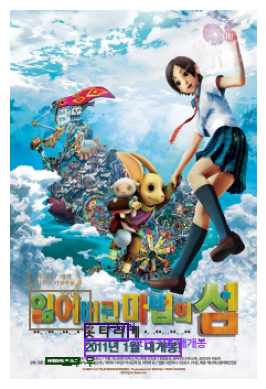

12
액션 단어 : 개봉
코미디 단어 : 오부
애니 단어 : 언어
장르 : 애니메이션
액션 장르의 빈도수: 1
애니메이션 장르의 빈도수: 1
코미디 장르의 빈도수: 1
드라마 장르의 빈도수: 0
공포(호러) 장르의 빈도수: 0


In [11]:
from collections import Counter

num = 0
img = X[num]
genre = y[num]

# 이미지 텍스트 추출
ocr = Ocr(img)
ocr.text_detect()
i2t_text = ocr.image_to_text()
# print(y[num])
gn = Get_Nouns(i2t_text)
nouns = gn.get_nouns_list()

act_freq = 0
ani_freq = 0
com_freq = 0
dra_freq = 0
hor_freq = 0
# etc_freq = 0

print(len(nouns))

# 입력한 단어들의 빈도수 확인
for word in nouns:
    if word in act_nouns:
        print(f"액션 단어 : {word}")
        act_freq += 1
    elif word in ani_nouns:
        print(f"애니 단어 : {word}")
        ani_freq += 1
    elif word in com_nouns:
        print(f"코미디 단어 : {word}")
        com_freq += 1
    elif word in dra_nouns:
        print(f"드라마 단어 : {word}")
        dra_freq += 1
    elif word in hor_nouns:
        print(f"공포 단어 : {word}")
        hor_freq += 1
    else:
        # print(f"기타 단어 : {word}")
        # etc_freq += 1
        pass

print(f"장르 : {genre}")
print(f"액션 장르의 빈도수: {act_freq}")
print(f"애니메이션 장르의 빈도수: {ani_freq}")
print(f"코미디 장르의 빈도수: {com_freq}")
print(f"드라마 장르의 빈도수: {dra_freq}")
print(f"공포(호러) 장르의 빈도수: {hor_freq}")
# print(f"기타 장르의 빈도수: {etc_freq}")

In [12]:
i2t_text

(['얇에;', '롯타라', '2t년 1업 대개봉', '오부 무'],
 ['얇에', '롯타라', '2년 1월 대개봉]', 'None'],
 ['얇에;', '롯타라', '2년 1월 대개봉]', 'None'],
 ['없어', '못타라', '깨번 I편 더거불다', 'None'],
 ['잃이;', '못타라', '20년 1업 대개봉C', 'None'],
 ['언어', 'None', 'None', 'None'],
 ['냄이', 'None', 'None', 'None'],
 ['None', '꿈미내', '슈0키꽤', 'None'])

In [13]:
img.shape

(336, 224, 3)

In [14]:
import pandas as pd

columns = ['act_freq', 'ani_freq', 'com_freq', 'dra_freq', 'hor_freq']
df = pd.DataFrame(columns=columns)
df

,act_freq,ani_freq,com_freq,dra_freq,hor_freq


In [9]:
from tqdm import tqdm

# num = list(range(5718, 7005))

# for num in tqdm(len(X)):
for num in tqdm(num):
    # print(num)
    img = X[num]
    genre = y[num]

    try:
        # 이미지 텍스트 추출
        ocr = Ocr(img)
        # ocr.text_detect()
        i2t_text = ocr.image_to_text()
        # print(y[num])
        gn = Get_Nouns(i2t_text)
        nouns = gn.get_nouns_list()

        act_freq = 0
        ani_freq = 0
        com_freq = 0
        dra_freq = 0
        hor_freq = 0

        # 입력한 단어들의 빈도수 확인
        for word in nouns:
            if word in act_nouns:
                act_freq += 1
            elif word in ani_nouns:
                ani_freq += 1
            elif word in com_nouns:
                com_freq += 1
            elif word in dra_nouns:
                dra_freq += 1
            elif word in hor_nouns:
                hor_freq += 1
            else:
                # etc_freq += 1
                pass

        df.loc[num, 'act_freq'] = act_freq
        df.loc[num, 'ani_freq'] = ani_freq
        df.loc[num, 'com_freq'] = com_freq
        df.loc[num, 'dra_freq'] = dra_freq
        df.loc[num, 'hor_freq'] = hor_freq
        # df.loc[num, 'etc_freq'] = etc_freq

    except:
        print(num)
        df.loc[num, 'act_freq'] = 0
        df.loc[num, 'ani_freq'] = 0
        df.loc[num, 'com_freq'] = 0
        df.loc[num, 'dra_freq'] = 0
        df.loc[num, 'hor_freq'] = 0
        # df.loc[num, 'etc_freq'] = 0

    df.to_csv("c:/3rd_project/data/Train/freq_1011_2.csv", index=None)
df

  4%|▍         | 54/1287 [02:38<54:39,  2.66s/it]  

5771


  5%|▍         | 58/1287 [02:49<54:44,  2.67s/it]

5775


 10%|▉         | 127/1287 [06:21<1:01:12,  3.17s/it]

5844


 10%|█         | 132/1287 [06:39<1:03:29,  3.30s/it]

5849


 10%|█         | 134/1287 [06:45<1:04:22,  3.35s/it]

5851


 12%|█▏        | 158/1287 [07:59<58:14,  3.10s/it]  

5875


 14%|█▍        | 186/1287 [09:25<53:34,  2.92s/it]  

5903


 16%|█▋        | 211/1287 [10:40<50:36,  2.82s/it]  

5928


 25%|██▍       | 320/1287 [16:09<49:50,  3.09s/it]

6037


 30%|██▉       | 382/1287 [19:16<42:02,  2.79s/it]

6099


 34%|███▍      | 438/1287 [22:05<45:24,  3.21s/it]

6155


 44%|████▍     | 566/1287 [28:34<38:26,  3.20s/it]

6283


 57%|█████▋    | 735/1287 [36:00<25:01,  2.72s/it]

6452


 59%|█████▉    | 764/1287 [37:17<23:46,  2.73s/it]

6481


 63%|██████▎   | 810/1287 [39:24<21:33,  2.71s/it]

6527


 65%|██████▌   | 842/1287 [40:50<19:06,  2.58s/it]

6559


 66%|██████▌   | 844/1287 [40:54<18:45,  2.54s/it]

6561


 66%|██████▌   | 845/1287 [40:57<18:39,  2.53s/it]

6562


 69%|██████▉   | 885/1287 [42:47<16:41,  2.49s/it]

6602


 71%|███████▏  | 920/1287 [44:21<15:23,  2.52s/it]

6637


 73%|███████▎  | 938/1287 [45:11<16:36,  2.86s/it]

6655


 74%|███████▍  | 952/1287 [45:47<15:24,  2.76s/it]

6669


 75%|███████▌  | 968/1287 [46:35<16:15,  3.06s/it]

6685


 83%|████████▎ | 1062/1287 [51:31<11:29,  3.06s/it]

6779


 85%|████████▌ | 1095/1287 [53:16<09:56,  3.11s/it]

6812


 86%|████████▌ | 1104/1287 [53:44<10:09,  3.33s/it]

6821


 88%|████████▊ | 1136/1287 [55:25<07:35,  3.02s/it]

6853


 95%|█████████▌| 1224/1287 [1:00:02<03:11,  3.04s/it]

6941


 98%|█████████▊| 1260/1287 [1:01:54<01:23,  3.10s/it]

6977


100%|██████████| 1287/1287 [1:03:20<00:00,  2.95s/it]


,act_freq,ani_freq,com_freq,dra_freq,hor_freq
5718,2,3,0,0,0
5719,4,0,2,2,0
5720,1,0,0,0,0
5721,2,0,0,1,0
5722,0,0,0,0,0
...,...,...,...,...,...
7000,3,1,0,0,0
7001,2,1,0,1,0
7002,0,0,0,0,0
7003,12,2,3,2,0


In [10]:
df2 = pd.read_csv('c:/3rd_project/data/Train/freq_1011.csv')
df2

,act_freq,ani_freq,com_freq,dra_freq,hor_freq
0,1,1,1,0,0
1,0,0,0,0,0
2,7,2,1,1,0
3,1,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
5713,0,0,0,0,0
5714,6,0,0,0,0
5715,6,1,0,2,0
5716,4,1,1,0,0


In [11]:
df3 = pd.concat([df2, df], ignore_index=True)
df3

,act_freq,ani_freq,com_freq,dra_freq,hor_freq
0,1,1,1,0,0
1,0,0,0,0,0
2,7,2,1,1,0
3,1,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
7000,3,1,0,0,0
7001,2,1,0,1,0
7002,0,0,0,0,0
7003,12,2,3,2,0


In [12]:
df3.to_csv("c:/3rd_project/data/Train/freq_1012.csv", index=None)